In [1]:
# overwriting notebook style
from IPython.display import display, HTML
display(HTML("<style>.jp-Cell { width: 80% !important; }</style>"))

## Import modules

In [38]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# fundamentals

from importlib import reload

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# global settings - global_settings.py

if 'global_settings' in dir():
    del global_settings

from global_settings import *
import global_settings
global_settings = reload(global_settings)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# custom functions collection - functions.py

if 'functions' in dir():
    del functions

from functions import *
import functions
functions = reload(functions)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# local variables

debug_mode = False

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectPercentile

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# pipeline

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Evaluation, optimization, metrics

from sklearn.metrics import recall_score, precision_score, precision_recall_curve, f1_score,\
roc_auc_score, roc_curve, auc, classification_report, confusion_matrix,\
fbeta_score, make_scorer
# f2 is fbeta with beta=2.0
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# model

from sklearn.linear_model import LogisticRegression

In [39]:
global_settings??

Type:        module
String form: <module 'global_settings' from '/Users/rafalfedro/Workbench/courses and tests/stackFuel/Portfolio/Portfolinoes/Notebooks/global_settings.py'>
File:        ~/Workbench/courses and tests/stackFuel/Portfolio/Portfolinoes/Notebooks/global_settings.py
Source:     
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# import essential modules

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# global variables

random_seed = 42
random_seed_split = 0
pd.options.display.float_format = '{:.2f}'.format

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# color palette

color_palette = {0:'#85d4c8', 1:'#fc6226', 2:'#fc037f'} #db4125 fc6226 0 - main_color, 1 - accent_color
sns_color_palette = {0:'#51ad9f', 1:'#fc6226'}

# - - - - - - - - - - - - - - - - - - - - - - - - - 

In [5]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# suppress warnings

from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Prepare F2 metric
**F2** is a variant of harmonic mean between recall and precision, with a stronger weight on the **recall**

Using such a metric for measuring our model's performance is beneficial, since:
- we want to classify correctly as many observations close to leaving (approaching the threshold of target class 1)(optimize FN -> recall)
- at the same time we want to optimize resources used to keep the people falsely predicted as leaving (FP - False Positive -> precision), precision plays a factor, but it's less important than recall

**F0.5** - f-beta with beta=0.5 (more weight on **precision**, less weight on **recall**)\
**F1** - f-beta with beta=1\
**F2** - f-beta with beta=2 (more weight on **recall**, less on **precision**)

In [6]:
from sklearn.metrics import make_scorer,fbeta_score

def f2_score(y_true, y_pred):
    score = fbeta_score(y_true, y_pred, beta=2)
    return score

def f2():
    return make_scorer(f2_score)

## Load, clean and resample the data

In [7]:
raw_data = pd.read_csv('../Data/HR_Analytics.csv')

In [8]:
def sampling_data(DF):
    '''Only to be performed on the train-sets. Handles the outliers, encodes target vector and removes duplicates.
    '''
    df = DF.drop_duplicates()
    # not sure if it's a good practice to do it on the test set, maybe after split?
    # if happens after the split - requires reindexing of the target vector
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # Attrition label encoding
    df['Attrition'].replace({'Yes': 1, 'No': 0}, inplace=True)
    
    return df

data = sampling_data(raw_data)

/var/folders/8b/8bwq4wfs017glw29db6mn8z40000gn/T/ipykernel_80038/309428036.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Attrition'].replace({'Yes': 1, 'No': 0}, inplace=True)


In [9]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# train-test split

Xtrain, Xtest, ytrain, ytest = train_test_split(data.drop('Attrition', axis=1), 
                                                data['Attrition'], 
                                                test_size=0.2, 
                                                shuffle=True,
                                                stratify=data['Attrition'], 
                                                random_state=random_seed_split)
                                                # is stratify practically like undersampling or keeps the original proportion?

In [10]:
# Assign columns to column groups
catcols = ['AgeGroup', 'SalarySlab', 'Department', 'EducationField', 'JobRole', 'MaritalStatus']
numcols = ['Education', 'EnvironmentSatisfaction', 'BusinessTravel', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 
           'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance', 'OverTime', 'Gender', 'Age', 'DailyRate', 'DistanceFromHome', 
           'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 
           'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
delcols = ['EmpID', 'EmployeeNumber']

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# clean data

def clean_data(DF, delcols=delcols):
    # df = DF.drop_duplicates()  
    df = DF.copy()
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # drop columns with 1 unique value (std=0)
    
    mask_single_value = list(df.nunique().index.values[df.nunique() == 1])
    df = df.loc[:, ~df.columns.isin(mask_single_value)]
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # drop prediction-useless columns
    
    for column in delcols:
        if column in df.columns.values:
            df = df.drop(column, axis=1)
        
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # categ. - label encoding
    
    df['AgeGroup'].replace({'18-25': 0,
                            '26-35': 1,
                            '36-45': 2,
                            '46-55': 3,
                            '55+': 4
                           }, inplace=True)
    df['BusinessTravel'].replace({'Non-Travel': 0,
                                   'Travel_Rarely': 1,
                                   'TravelRarely': 1,
                                   'Travel_Frequently': 2
                                  }, inplace=True)
    df['Gender'].replace({'Male': 1, 'Female': 0}, inplace=True)   # potentially better to one-hot encode
    df['MaritalStatus'].replace({'Single': 0,
                                 'Divorced': 1,
                                 'Married': 2
                                }, inplace=True)
    df['SalarySlab'].replace({'Upto 5k': 0,
                              '5k-10k': 1,
                              '10k-15k': 2,
                              '15k+': 3}, inplace=True)
    df['OverTime'].replace({'Yes': 1, 'No': 0}, inplace=True)
    df['PerformanceRating'].replace({3: 0, 4: 1}, inplace=True)
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # NaN handling: fillna with median (temp)
        
    #df = df.dropna(axis=0)
    df = df.fillna(value={'YearsWithCurrManager': df.loc[:,'YearsWithCurrManager'].median()})
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # Data Types Conversion
    
    col_dtypes = {'YearsWithCurrManager': 'int8',
              'Department': 'category',
              'EducationField': 'category',
              'JobRole': 'category'
             }

    for key in col_dtypes:
        df[key] = df[key].astype(col_dtypes[key])
    
    return df

In [11]:
Xtrain = clean_data(Xtrain)
Xtest = clean_data(Xtest)

In [12]:
# Undersampling - reducing the number of Attrition = 0 / No

from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(random_state=random_seed)

X_under, y_under = undersampler.fit_resample(Xtrain, ytrain)

# class distribution
pd.crosstab(y_under, columns='count')

col_0,count
Attrition,
0,190
1,190


In [13]:
# Oversampling - increasing the minority class

from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

X_over, y_over = oversampler.fit_resample(Xtrain, ytrain)

# class distribution
pd.crosstab(y_over, columns='count')

col_0,count
Attrition,
0,988
1,988


In [14]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1178 entries, 1278 to 640
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Age                       1178 non-null   int64   
 1   AgeGroup                  1178 non-null   int64   
 2   BusinessTravel            1178 non-null   int64   
 3   DailyRate                 1178 non-null   int64   
 4   Department                1178 non-null   category
 5   DistanceFromHome          1178 non-null   int64   
 6   Education                 1178 non-null   int64   
 7   EducationField            1178 non-null   category
 8   EnvironmentSatisfaction   1178 non-null   int64   
 9   Gender                    1178 non-null   int64   
 10  HourlyRate                1178 non-null   int64   
 11  JobInvolvement            1178 non-null   int64   
 12  JobLevel                  1178 non-null   int64   
 13  JobRole                   1178 non-null   cate

### Prepare preprocessing

In [15]:
# define num_cols and cat_cols

num_cols = list(Xtrain.select_dtypes(include='number').columns.values)
cat_cols = list(Xtrain.select_dtypes(include='category').columns.values)

In [16]:
# main pipeline

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
knnimp = KNNImputer(add_indicator=True)
simpimp = SimpleImputer(strategy='median')
std = StandardScaler()

imputer = simpimp

catpipe = make_pipeline(encoder)
numpipe = Pipeline([('imputer', simpimp),
                    ('scaler', std)])

coltrans = ColumnTransformer(transformers=[('encoder', encoder, cat_cols),
                                           ('numpipe', numpipe, num_cols)], remainder='drop')
selection = SelectPercentile(percentile=90) # percentile=10

### Instantiate estimator

In [17]:
log = LogisticRegression(solver='saga',  
                         class_weight='balanced',
                         max_iter=int(1e4),
                         random_state=random_seed)

# check:
# solver='liblinear'

### Set search space

In [18]:
# np.set_printoptions(suppress=True) # to avoid scientific notation
# temp_x = np.linspace(start=0.01, stop=1, num=10, dtype='float')
# with logistic reg. you want to try the reg. values with increasing steps, not jumping from little regul. to a lot
temp_x = np.geomspace(start=0.001, stop=1000, num=14, dtype='float')
print(temp_x)

[1.00000000e-03 2.89426612e-03 8.37677640e-03 2.42446202e-02
 7.01703829e-02 2.03091762e-01 5.87801607e-01 1.70125428e+00
 4.92388263e+00 1.42510267e+01 4.12462638e+01 1.19377664e+02
 3.45510729e+02 1.00000000e+03]


In [19]:
search_space = {'estimator__C': np.geomspace(start=0.0041, stop=0.00416, num=20, dtype='float'),
                'estimator__penalty': ['l1', 'l2']  # l1 - lasso; l2 - ridge
                #'selector__percentile': [90]
                #'prepper__numpipe__imputer__strategy': ['mean', 'median']
               }

# np.geomspace(start=0.0041, stop=0.00416, num=20, dtype='float')  # best for 'saga'
# np.geomspace(start=0.21, stop=0.3, num=20, dtype='float')  # beginning of tunning of 'liblinear' 0.001 1000

## Pipeline finalization and grid search

In [36]:
pipe_log = Pipeline([('preproc', coltrans),
                     ('selector', selection),
                     ('estimator', log)])

pipe_log = GridSearchCV(estimator=pipe_log,
                        param_grid=search_space,
                        scoring=f2(),
                        cv=6,
                        verbose=3,
                        n_jobs=-1)
pipe_log.fit(Xtrain, ytrain)
#model_svc = pipe_svc.best_estimator_
#print(grid_svc.best_estimator_)

print(pipe_log.best_params_)
print(f'Best F2 score: {pipe_log.best_score_.mean():.2%}')
f_divline()

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# prediction on the test set

ypred = pipe_log.best_estimator_.predict(Xtest)

print(f'F2 score on test set:\t{f2_score(ytest, ypred):.2%}')
print(f'Recall on test set:\t{recall_score(ytest, ypred):.2%}')
print(f'Precision on test set:\t{precision_score(ytest, ypred):.2%}')

Fitting 6 folds for each of 40 candidates, totalling 240 fits
{'estimator__C': 0.004156820326416346, 'estimator__penalty': 'l2'}
Best F2 score: 61.83%

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

F2 score on test set:	63.36%
Recall on test set:	78.72%
Precision on test set:	35.58%


In [40]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# ROC visualization

def plot_roc(pipe, Xtest, ytest):
    
    yscores = pipe.predict_proba(Xtest)[:,1]
    fpr, tpr, _ = roc_curve(ytest, yscores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color=color_palette[1], lw=1.2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=1.2, linestyle=(0, (8,10)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

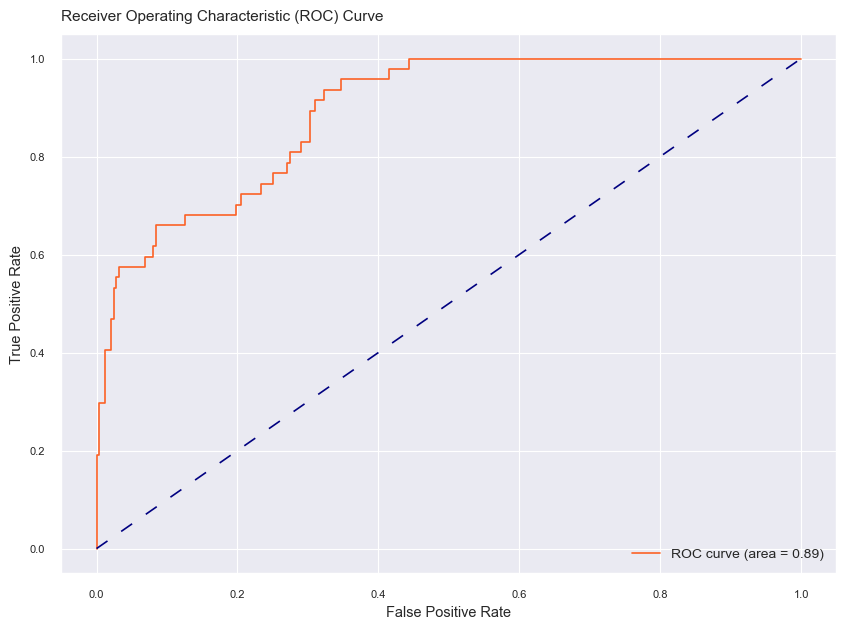

In [41]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# ROC plot

graph_roc = plot_roc(pipe_log, Xtest, ytest)

In [42]:
pd.options.display.float_format = '{:.5f}'.format

results = pd.DataFrame(pipe_log.cv_results_).sort_values(by='mean_test_score', ascending=False).head(8).T
results

,39,37,33,23,29,21,19,17
mean_fit_time,0.00992,0.01014,0.01127,0.01379,0.01048,0.01095,0.01240,0.01053
std_fit_time,0.00030,0.00056,0.00204,0.00415,0.00151,0.00139,0.00207,0.00140
mean_score_time,0.00215,0.00222,0.00235,0.00252,0.00287,0.00250,0.00268,0.00337
std_score_time,0.00009,0.00020,0.00022,0.00045,0.00114,0.00045,0.00061,0.00153
param_estimator__C,0.00416,0.00416,0.00415,0.00413,0.00414,0.00413,0.00413,0.00413
param_estimator__penalty,l2,l2,l2,l2,l2,l2,l2,l2
params,"{'estimator__C': 0.00416, 'estimator__penalty'...","{'estimator__C': 0.004156820326416346, 'estima...","{'estimator__C': 0.004150468268490513, 'estima...","{'estimator__C': 0.004134630557660767, 'estima...","{'estimator__C': 0.004144125917176158, 'estima...","{'estimator__C': 0.00413147027507366, 'estimat...","{'estimator__C': 0.004128312408031523, 'estima...","{'estimator__C': 0.00412515695468804, 'estimat..."
split0_test_score,0.64171,0.64171,0.64171,0.64171,0.64171,0.64171,0.64171,0.64171
split1_test_score,0.65000,0.65000,0.65000,0.65000,0.65000,0.65000,0.65000,0.65000
split2_test_score,0.60109,0.60109,0.60109,0.60109,0.60109,0.60109,0.60109,0.60109


## Feature importance

In [43]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Estimate feature importance through permutation importance

result = permutation_importance(pipe_log, Xtrain, ytrain, n_repeats=50, random_state=random_seed)
importance_scores = abs(result.importances_mean)

original_columns = Xtrain.columns
feature_importance_list = list(zip(original_columns, importance_scores))
sorted_feature_importance = sorted(feature_importance_list, key=lambda x: x[1], reverse=False)
orig_sorted_features, orig_sorted_importance = zip(*sorted_feature_importance)

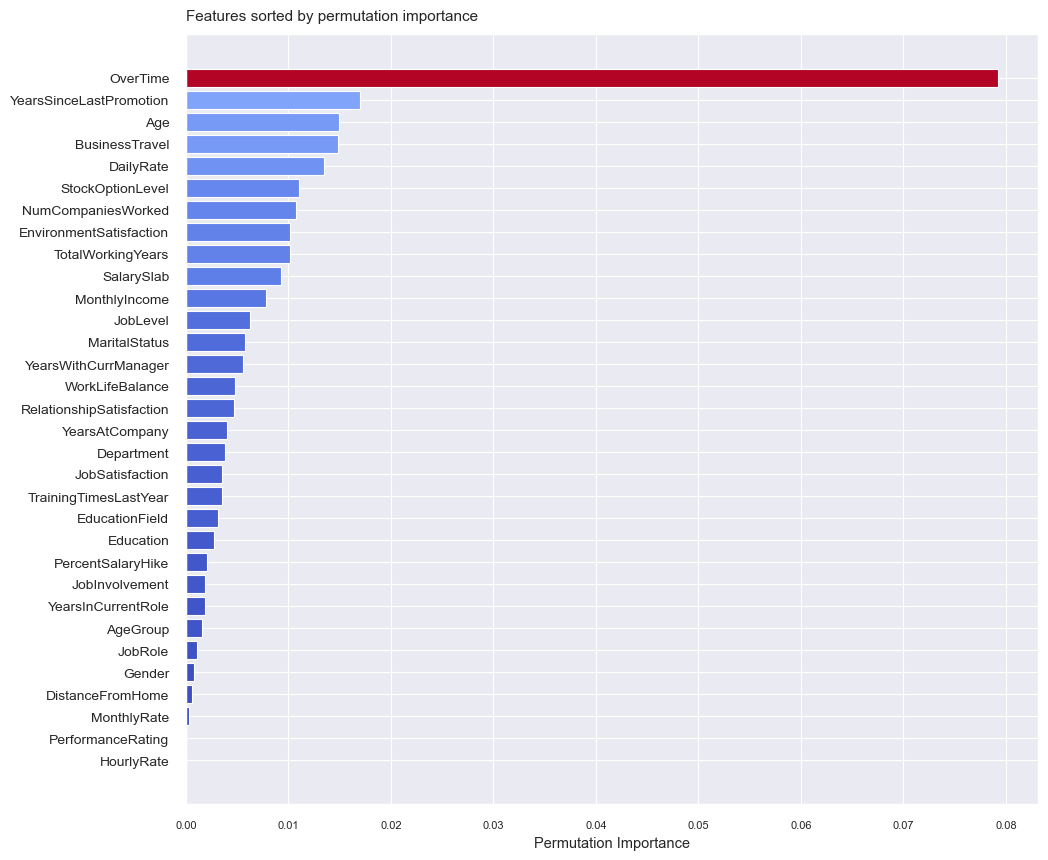

In [44]:
plt.rc('ytick', labelsize=10)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Visualization

import matplotlib as mpl
from matplotlib.cm import get_cmap

colors = []
cmap = mpl.colormaps['coolwarm']

# scale data
data = orig_sorted_importance
denominator = max(data) - min(data) # max(data) - min(data)
scaled_data = [(datum - min(data)) / denominator for datum in data]

for decimal in scaled_data:
    colors.append(cmap(decimal))


fig_feature_importance, ax = plt.subplots(figsize=(11,10))

ax.barh(orig_sorted_features, orig_sorted_importance, color=colors)
ax.set(title='Features sorted by permutation importance',
      xlabel='Permutation Importance');

#ax.set_xticklabels({:.2%})

In [45]:
# orig_sorted_importance

In [46]:
abs(result.importances_mean)

array([0.01493226, 0.00162061, 0.01488541, 0.01351182, 0.00387478,
       0.00063329, 0.00271746, 0.00319293, 0.01016592, 0.00077959,
       0.        , 0.00188774, 0.00628829, 0.00112858, 0.00356889,
       0.00574303, 0.00779523, 0.00928399, 0.00026856, 0.01072798,
       0.07920542, 0.00203303, 0.        , 0.00472487, 0.01102432,
       0.01012971, 0.00350169, 0.00483909, 0.003983  , 0.00185007,
       0.01701696, 0.00554758])